In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

import imgaug.augmenters as iaa

from astrodet import astrodet as toolkit
from PIL import Image, ImageEnhance
from astropy.visualization import make_lupton_rgb
from astrodet.detectron import plot_stretch_Q
from detectron2.utils.file_io import PathManager
from iopath.common.file_io import file_lock

import logging
logger = logging.getLogger(__name__)
import shutil
import json

from detectron2.structures import BoxMode
from astropy.io import fits
import glob

import skimage.metrics

In [2]:
# Print the versions to test the imports and so we know what works
print(detectron2.__version__)
print(np.__version__)
print(cv2.__version__)

0.6
1.20.3
4.5.3


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

### First, get some HSC data from training_data.ipynb

### Register HSC training data

The file metadata for each dataset is specified with the `filesnames_dict`. We will specify the filters first, then populate the filenames in the dataset directory.

For a custom dataset, this dictionary needs to be populated correctly for your data.

In [4]:
dirpath = '/home/shared/hsc/HSC/HSC_DR3/data/' # Path to dataset
output_dir = '/home/shared/hsc/HSC/HSC_DR3/models/'

dataset_names = ['train', 'test', 'val'] 

In [5]:
#this block is for debug purposes, set to -1 to include every sample
sampleNumbers = 100

In [6]:

#Yufeng Jun19 add test here
dataset_names = ['train','test', 'val'] # train
filenames_dict_list = [] # List holding filenames_dict for each dataset

for i, d in enumerate(dataset_names):
    data_path = os.path.join(dirpath, d)

    # Get dataset dict info
    filenames_dict = {}
    filenames_dict['filters'] = ['g', 'r', 'i']

    # Get each unqiue tract-patch in the data directory
    #file = full path name
    files = glob.glob(os.path.join(data_path, '*_scarlet_segmask.fits'))
    if sampleNumbers != -1:
        files = files[:sampleNumbers]
    # s = sample name
    s = [os.path.basename(f).split('_scarlet_segmask.fits')[0] for f in files]
    #print(f'Tract-patch List: {s}')
    for f in filenames_dict['filters']:
        filenames_dict[f] = {}
        # List of image files in the dataset
        #Yufeng dec/21  [Errno 2] No such file or directory: '/home/shared/hsc/test/G-I-8525-4,5-c5_scarlet_img'
        #filenames_dict[f]['img'] = [os.path.join(data_path, f'{f.upper()}-{tract_patch}_scarlet_img.fits') for tract_patch in s]
        #Yufeng jan 18 f.upper() indicates filter, tract_patch[1:] removes the default I band in the front
        filenames_dict[f]['img'] = [os.path.join(data_path, f.upper() + f'{tract_patch[1:]}_scarlet_img.fits') for tract_patch in s]
        # List of mask files in the dataset
        #Yufeng jan 18 all mask files are in the I band
        filenames_dict[f]['mask'] = [os.path.join(data_path, f'{tract_patch}_scarlet_segmask.fits') for tract_patch in s]
        
    filenames_dict_list.append(filenames_dict)

In [70]:
ftrain=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/train/', '*_scarlet_segmask.fits'))
ftest=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/test/', '*_scarlet_segmask.fits'))
fval=glob.glob(os.path.join('/home/shared/hsc/HSC/HSC_DR3/data/val/', '*_scarlet_segmask.fits'))
print(len(ftrain),len(ftest),len(fval))

print(len(ftest)/len(ftrain))

11889 2364 2388
0.19883926318445622


In [7]:
#number of total samples
print('# of train sample: ', len(filenames_dict_list[0]['g']['img']))
print('# of test sample: ', len(filenames_dict_list[1]['g']['img']))

# of train sample:  10
# of test sample:  10


In [5]:
garbage_data = []
def get_astro_dicts(filename_dict):
    
    """
    This can needs to be customized to your trianing data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            category_ids = [hdu.header["CAT_ID"] for hdu in hdul]
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        #img = read_image(record, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
        #img0std = np.std(np.trim_zeros(img[:,:,0].flatten()))
        #if img0std > 10:
        #    img1std = np.std(np.trim_zeros(img[:,:,1].flatten()))
        #    if img1std > 10:
        #        img2std = np.std(np.trim_zeros(img[:,:,2].flatten()))
        #        if img2std > 10:
        #            dataset_dicts.append(record)
        #        else:
        #            garbage_data.append(record)
        #    else:
        #        garbage_data.append(record)
        #else:
        #    garbage_data.append(record)
            
    return dataset_dicts

In [6]:
garbage_data = []
def get_astro_dicts_new(filename_dict):
    
    """
    This can needs to be customized to your trianing data format
    
    """
        
    dataset_dicts = []
    filters = list(filename_dict.keys())
    #yufeng april5: why only 1st filter
    f = filename_dict['filters'][0] # Pick the 1st filter for now
    
    # Filename loop
    for idx, (filename_img, filename_mask) in enumerate(zip(filename_dict[f]['img'], filename_dict[f]['mask'])):
        record = {}

        # Open FITS image of first filter (each should have same shape)
        with fits.open(filename_img, memmap=False, lazy_load_hdus=False) as hdul:
            height, width = hdul[0].data.shape
            
        # Open each FITS mask image
        with fits.open(filename_mask, memmap=False, lazy_load_hdus=False) as hdul:
            hdul = hdul[1:]
            sources = len(hdul)
            # Normalize data
            data = [hdu.data for hdu in hdul]
            category_ids = [hdu.header["CAT_ID"] for hdu in hdul]
            ellipse_pars = [hdu.header["ELL_PARM"] for hdu in hdul]
            bbox = [list(map(int, hdu.header["BBOX"].split(','))) for hdu in hdul]
            area = [hdu.header["AREA"] for hdu in hdul]

        # Add image metadata to record (should be the same for each filter)
        for f in filename_dict['filters']:
            record[f"filename_{f.upper()}"] = filename_dict[f]['img'][idx]
        # Assign file_name
        record[f"file_name"] = filename_dict[filename_dict['filters'][0]]['img'][idx]
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []

        # Generate segmentation masks from model
        for i in range(sources):
            image = data[i]
            # Why do we need this?
            if len(image.shape) != 2:
                continue
            height_mask, width_mask = image.shape
            # Create mask from threshold
            mask = data[i]
            # Smooth mask
            #mask = cv2.GaussianBlur(mask, (9,9), 2)
            x,y,w,h = bbox[i] # (x0, y0, w, h)

            # https://github.com/facebookresearch/Detectron/issues/100
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                # contour = [x1, y1, ..., xn, yn]
                contour = contour.flatten()
                if len(contour) > 4:
                    contour[::2] += (x-w//2)
                    contour[1::2] += (y-h//2)
                    segmentation.append(contour.tolist())
            # No valid countors
            if len(segmentation) == 0:
                continue

            # Add to dict
            obj = {
                "bbox": [x-w//2, y-h//2, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i],
                "ellipse_pars": ellipse_pars[i]
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        #img = read_image(record, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
        #img0std = np.std(np.trim_zeros(img[:,:,0].flatten()))
        #if img0std > 10:
        #    img1std = np.std(np.trim_zeros(img[:,:,1].flatten()))
        #    if img1std > 10:
        #        img2std = np.std(np.trim_zeros(img[:,:,2].flatten()))
        #        if img2std > 10:
        #            dataset_dicts.append(record)
        #        else:
        #            garbage_data.append(record)
        #    else:
        #        garbage_data.append(record)
        #else:
        #    garbage_data.append(record)
            
    return dataset_dicts

Now, we register the dataset following the detectron2 documention.

In [9]:
#Yufeng 2022 Oct5: For unknown reason, do not use iteration to assign metadata
#for i, d in enumerate(dataset_names):
#    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts(filenames_dict_list[i]))
#    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy","other"], things_colors = ['blue', 'gray', 'green'])
#astro_metadata = MetadataCatalog.get("astro_train")

DatasetCatalog.register("astro_train", lambda: get_astro_dicts(filenames_dict_list[0]))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy","other"])
DatasetCatalog.register("astro_test", lambda: get_astro_dicts(filenames_dict_list[1]))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy","other"])
DatasetCatalog.register("astro_val", lambda: get_astro_dicts(filenames_dict_list[2]))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy","other"])

astrotrain_metadata = MetadataCatalog.get("astro_train") # astro_test dataset needs to exist
astrotest_metadata = MetadataCatalog.get("astro_test") # astro_test dataset needs to exist
astrotval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist


In [10]:


#code snippet for unregistering if you want to change something

if "astro_train" in DatasetCatalog.list():
    print('removing astro_train')
    DatasetCatalog.remove("astro_train")
    MetadataCatalog.remove("astro_train")
    
if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    MetadataCatalog.remove("astro_test")
    
if "astro_val" in DatasetCatalog.list():
    print('removing astro_val')
    DatasetCatalog.remove("astro_val")
    MetadataCatalog.remove("astro_val")







removing astro_train
removing astro_test
removing astro_val


In [7]:
def get_data_from_json(file):
    # Opening JSON file
    with open(file, 'r') as f:
        data = json.load(f)
    return data

In [8]:
trainfile='/home/shared/hsc/HSC/HSC_DR3/data/train.json'
testfile='/home/shared/hsc/HSC/HSC_DR3/data/test_smallest.json'
valfile='/home/shared/hsc/HSC/HSC_DR3/data/val_smallest.json'

DatasetCatalog.register("astro_train", lambda: get_data_from_json(trainfile))
MetadataCatalog.get("astro_train").set(thing_classes=["star", "galaxy","other"])
#astrotrain_metadata = MetadataCatalog.get("astro_train") # astro_test dataset needs to exist

DatasetCatalog.register("astro_test", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_test").set(thing_classes=["star", "galaxy","other"])
#astrotest_metadata = MetadataCatalog.get("astro_test") # astro_test dataset needs to exist


DatasetCatalog.register("astro_val", lambda: get_data_from_json(testfile))
MetadataCatalog.get("astro_val").set(thing_classes=["star", "galaxy","other"])
#astroval_metadata = MetadataCatalog.get("astro_val") # astro_test dataset needs to exist


astro_metadata = MetadataCatalog.get("astro_train")

In [39]:
datadir='/home/shared/hsc/HSC/HSC_DR3/data/'
t0 = time.time()
dataset_dicts_hsc = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts_hsc[d] = get_data_from_json(datadir+dataset_names[i]+'_full.json')
    
print('Took ', time.time()-t0, 'seconds for samples')

Loading train
Loading test
Loading val


KeyboardInterrupt: 

In [47]:
datadir='/home/shared/hsc/decam/decam_data/'
t0 = time.time()
dataset_dicts_decam = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts_decam[d] = get_data_from_json(datadir+dataset_names[i]+'.json')
    
print('Took ', time.time()-t0, 'seconds for samples')

Loading train
Loading test
Loading val
Took  2.116215705871582 seconds for samples


In [38]:
len(dataset_dicts_hsc['train'])

2000

In [25]:
instances_list=[]
for i in range(len(dataset_dicts['train'])):
    instances = len(dataset_dicts['train'][i]['annotations'])
    instances_list.append(instances)
instances_list = np.array(instances_list)


602.0


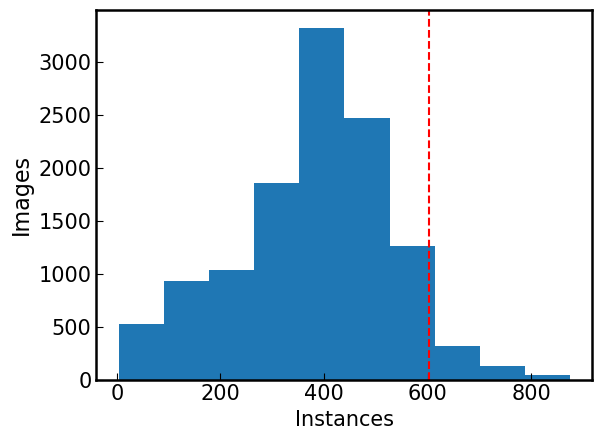

In [36]:
pcen = np.percentile(instances_list,95)
print(pcen)
plt.hist(instances_list)
plt.axvline(pcen,linestyle='--',color='r')
plt.xlabel('Instances',fontsize=15)
plt.ylabel('Images', fontsize=16)
plt.show()

In [65]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asarray(a)
    m = a.max()
    sd = a.std()
    return m/sd

In [83]:
snrs_hsc = []
snrs_hsc_raw = []

for d in dataset_dicts_hsc['train']:
    im = rescale_image(d,normalize='zscore',dtype=np.int16)
    snr = signaltonoise(im)
    snrs_hsc.append(snr)
    
    imraw = return_image(d)
    snr = signaltonoise(imraw)
    snrs_hsc_raw.append(snr)
    


In [86]:
snrs_hsc_lupsat =[]
for d in dataset_dicts_hsc['train']:
    im = rescale_image(d,normalize='lupton',dtype=np.uint8)
    snr = signaltonoise(im)
    snrs_hsc_lupsat.append(snr)


/tmp/ipykernel_1610400/931705083.py:19: RuntimeWarning: invalid value encountered in true_divide
  z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_1610400/931705083.py:20: RuntimeWarning: invalid value encountered in true_divide
  r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_1610400/931705083.py:21: RuntimeWarning: invalid value encountered in true_divide
  g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)


In [84]:
snrs_dec = []
snrs_dec_raw = []

for d in dataset_dicts_decam['train']:
    im = rescale_image(d,normalize='zscore',hsc=False,dtype=np.int16)
    snr = signaltonoise(im)
    snrs_dec.append(snr)
    
    imraw = return_image(d,hsc=False)
    snr = signaltonoise(imraw)
    snrs_dec_raw.append(snr)
    
    

In [87]:
snrs_dec_lupsat =[]
for d in dataset_dicts_decam['train']:
    im = rescale_image(d,normalize='lupton',dtype=np.uint8, hsc=False,)
    snr = signaltonoise(im)
    snrs_dec_lupsat.append(snr)

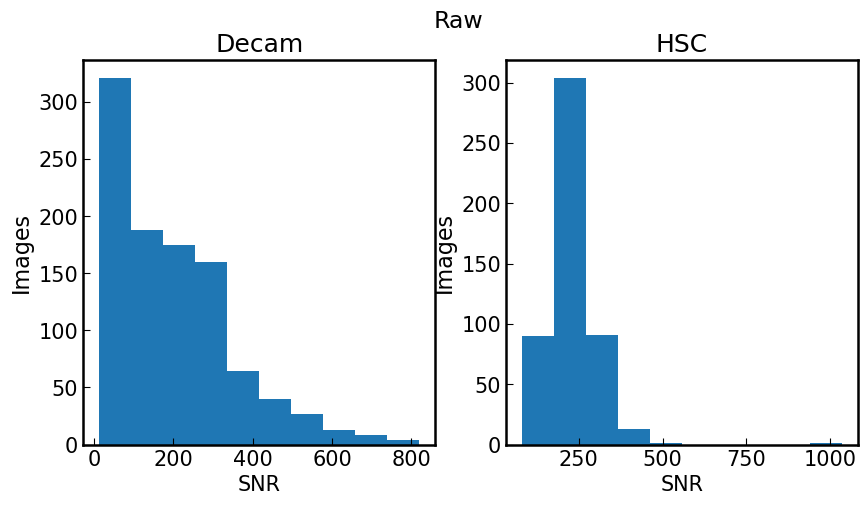

In [88]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(snrs_dec_raw)
ax[0].set_xlabel('SNR',fontsize=15)
ax[0].set_ylabel('Images', fontsize=16)
ax[0].set_title('Decam')

ax[1].hist(snrs_hsc_raw)
ax[1].set_xlabel('SNR',fontsize=15)
ax[1].set_ylabel('Images', fontsize=16)
ax[1].set_title('HSC')

plt.suptitle('Raw',fontsize=17)
plt.show()


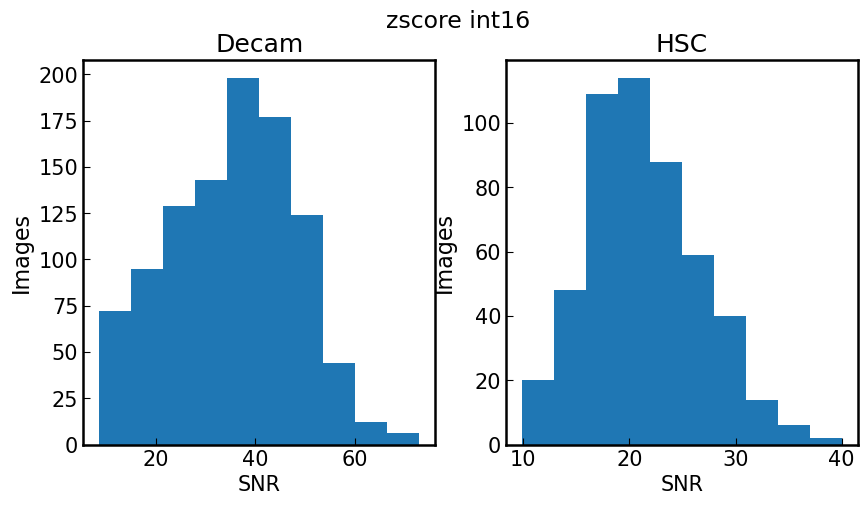

In [89]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(snrs_dec)
ax[0].set_xlabel('SNR',fontsize=15)
ax[0].set_ylabel('Images', fontsize=16)
ax[0].set_title('Decam')

ax[1].hist(snrs_hsc)
ax[1].set_xlabel('SNR',fontsize=15)
ax[1].set_ylabel('Images', fontsize=16)
ax[1].set_title('HSC')

plt.suptitle('zscore int16',fontsize=17)
plt.show()


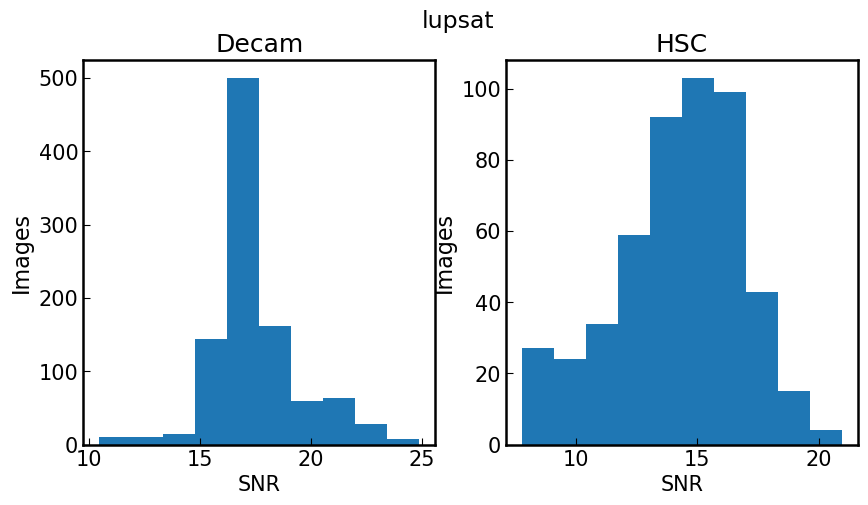

In [90]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(snrs_dec_lupsat)
ax[0].set_xlabel('SNR',fontsize=15)
ax[0].set_ylabel('Images', fontsize=16)
ax[0].set_title('Decam')

ax[1].hist(snrs_hsc_lupsat)
ax[1].set_xlabel('SNR',fontsize=15)
ax[1].set_ylabel('Images', fontsize=16)
ax[1].set_title('HSC')

plt.suptitle('lupsat',fontsize=17)
plt.show()

### Custom image reader

In [29]:
def return_image(dataset_dict, hsc=True):
    # Read image
    if hsc:
        g = fits.getdata(os.path.join(dataset_dict['filename_G']), memmap=False)
        r = fits.getdata(os.path.join(dataset_dict['filename_R']), memmap=False)
        z = fits.getdata(os.path.join(dataset_dict['filename_I']), memmap=False)
    else:
        filename = dataset_dict['file_name']
        g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
        r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
        z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    length, width = g.shape
    image = np.zeros([length, width, 3])
    
    # Options for contrast scaling
    
    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

In [1]:
def rescale_image(dataset_dict, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4,hsc=True):
    # Read image
    if hsc:
        g = fits.getdata(os.path.join(dataset_dict['filename_G']), memmap=False)
        r = fits.getdata(os.path.join(dataset_dict['filename_R']), memmap=False)
        z = fits.getdata(os.path.join(dataset_dict['filename_I']), memmap=False)
    else:
        filename = dataset_dict['file_name']
        g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
        r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
        z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
        # Contrast scaling / normalization
    I = (z + r + g)/3.0
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
        max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        #max_RGB = np.max([g,r,z])


        # avoid saturation
        r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        max_dtype = np.iinfo(dtype).max
        r = r*max_dtype
        g = g*max_dtype
        z = z*max_dtype
        
        
    elif normalize.lower() == 'zscore':
        
        
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
        
        #zsigma = np.nanstd(z)
        #rsigma = np.nanstd(r)
        #gsigma = np.nanstd(g)
        
        #z = A*(z - np.nanmean(z) - m)/zsigma
        #r = A*(r - np.nanmean(r) - m)/rsigma
        #g = A*(g - np.nanmean(g) - m)/gsigma
        
        max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        # avoid saturation
        r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        max_dtype = np.iinfo(dtype).max
        r = r*max_dtype
        g = g*max_dtype
        z = z*max_dtype
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')



    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

NameError: name 'np' is not defined

### Visualize Normalization method
Lupton normalization behaves linear at low intensities, and log at high intensities \n
Goal is to find the parameters that optimize the normalization

### Visualize Ground Truth Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1024.5, 1049.5, -0.5)

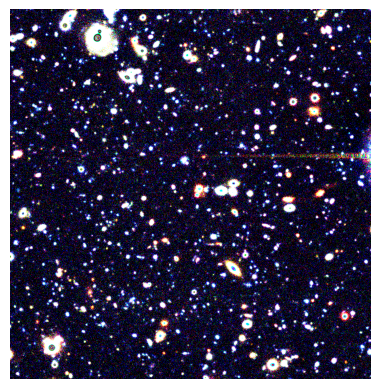

In [15]:
#d = random.sample(dataset_dicts_hsc['train'],1)[0]
im = rescale_image(d,normalize='zscore',dtype=np.int16)
plt.imshow(im)
plt.axis('off')


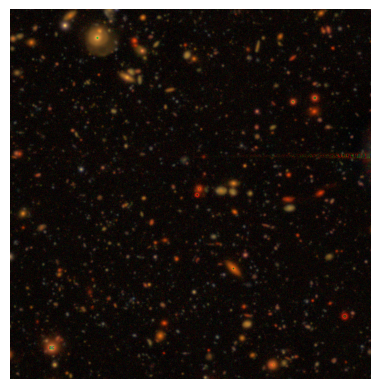

In [19]:
im = rescale_image(d,normalize='lupton',dtype=np.uint8,ceil_percentile=99.99)
plt.imshow(im)
plt.axis('off')
#plt.savefig('/home/g4merz/deblend/plots/luptonized.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


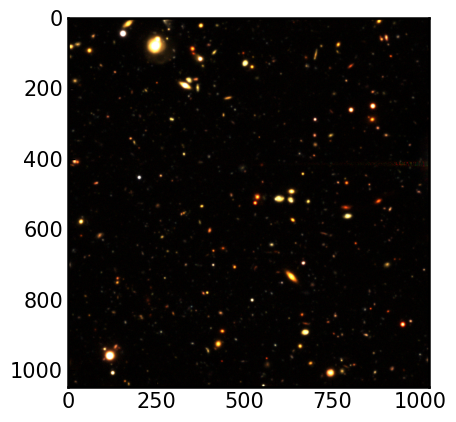

In [24]:
im = return_image(d)
plt.imshow(im)
plt.savefig('/home/g4merz/deblend/plots/raw.png')

In [ ]:
nsample = 1
maxInd = sampleNumbers
if maxInd == -1: maxInd = 10
randInd = np.random.randint(0,maxInd, nsample)
fig = plt.figure(figsize=(30,30*nsample*2))
i = 0
for ind in randInd:
    # Need to increase ceil_percentile if the data are saturating!
    d = dataset_dicts['train'][ind]
    print(ind)
    img = read_image(d, normalize="lupton", stretch=.8, Q=150, ceil_percentile=99.9995)
    visualizer = Visualizer(img, metadata=astrotrain_metadata)
    out = visualizer.draw_dataset_dict(d)
    ax1 = plt.subplot(nsample*2, 1, 2*i+1)
    ax1.imshow(out.get_image(), origin='upper')
    ax1.axis('off')
    ax2 = plt.subplot(nsample*2, 1, 2*i+2)
    ax2.imshow(img)
    i += 1

-395.3325260770975 2138.6556014749744
-256.7262185941043 1542.2437091102036
-255.00527256235827 1408.503787076855


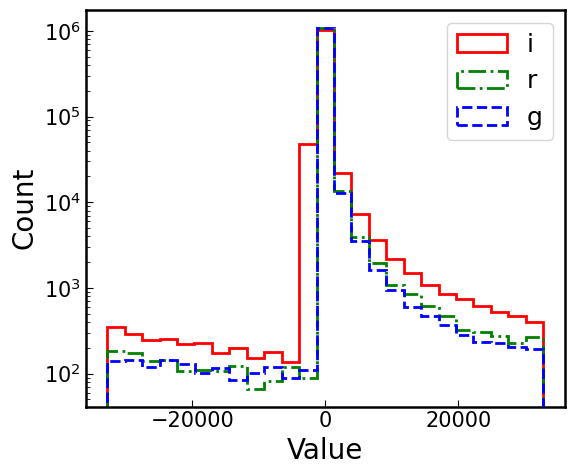

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
#91,28, 38 are  bad examples
d = dataset_dicts['train'][2]
img = rescale_image(d, normalize="zscore", stretch=.8, Q=150, ceil_percentile=99.9995,dtype=np.int16)
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1, label='i');
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2, label='r');
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3, label='g');
ax.set_xlabel('Value', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
img = img.copy()
img0 = np.trim_zeros(img[:,:,0].flatten())
img1 = np.trim_zeros(img[:,:,1].flatten())
img2 = np.trim_zeros(img[:,:,2].flatten())
print(np.mean(img0), np.std(img0))
print(np.mean(img1), np.std(img1))
print(np.mean(img2), np.std(img2))
#yufeng apr20 get rid of mean > mean+std
ax.legend(fontsize=18)

fig.tight_layout()

In [76]:
means = np.zeros(3)
stds = np.zeros(3)
tl = len(dataset_dicts['train'])

m0=m1=m2=0
s0=s1=s2=0

for d in dataset_dicts['train']:
    img = rescale_image(d, normalize="zscore", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.int16)
    m0+=img[:,:,0].mean()
    m1+=img[:,:,1].mean()
    m2+=img[:,:,2].mean()
    
    s0+=img[:,:,0].std()
    s1+=img[:,:,1].std()
    s2+=img[:,:,2].std()
    
means[0] = m0
means[1] = m1
means[2] = m2

stds[0] = s0
stds[1] = s1
stds[2] = s2
tl=len(dataset_dicts['train'])
print(means/tl)
print(stds/tl)

[-283.09874004 -238.71532866 -191.32925511]
[1673.00327372 1453.8772184  1191.24482461]


### Data Augmentation

In [10]:
from astrodet.astrodet import CustomAug
from detectron2.data.transforms.augmentation import KRandomAugmentationList

In [11]:

import imgaug.augmenters.flip as flip
import imgaug.augmenters.blur as blur


def hflip(image):
    return flip.fliplr(image)

#def gaussblur(image):
#    return blur.blur_gaussian_(image,sigma=np.random.random_sample()*4+2)

def gaussblur(image):
    aug = iaa.GaussianBlur(sigma=(0.0, np.random.random_sample()*4+2))
    return aug.augment_image(image)

def addelementwise16(image):
    aug = iaa.AddElementwise((-3276, 3276))
    return aug.augment_image(image)

def addelementwise8(image):
    aug = iaa.AddElementwise((-25, 25))
    return aug.augment_image(image)

In [12]:
def train_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = rescale_image(dataset_dict, normalize="lupton", stretch=5, Q=10, ceil_percentile=99.995, dtype=np.uint8)
    
    augs = KRandomAugmentationList([
        # my custom augs
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.RandomFlip(prob=0.5,horizontal=False,vertical=True),
        CustomAug(gaussblur,prob=1.0),
        CustomAug(addelementwise8,prob=1.0)
        #CustomAug(white),
        ],
        k=-1
    )
    
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

In [13]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = rescale_image(dataset_dict, normalize="lupton", stretch=5, Q=10, ceil_percentile=99.995, dtype=np.uint8)
    
    augs = T.AugmentationList([
        T.RandomCrop('relative',(0.5,0.5))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]


    instances = utils.annotations_to_instances(annos, image.shape[1:])
    instances = utils.filter_empty_instances(instances)

    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": image.shape[0],
        "width": image.shape[1],
        "image_id": dataset_dict["image_id"],
        "instances": instances,
        #"annotations": annos
    }


In [25]:
dictionary = iter(dataset_dicts['train'])


(1025, 1050, 3)


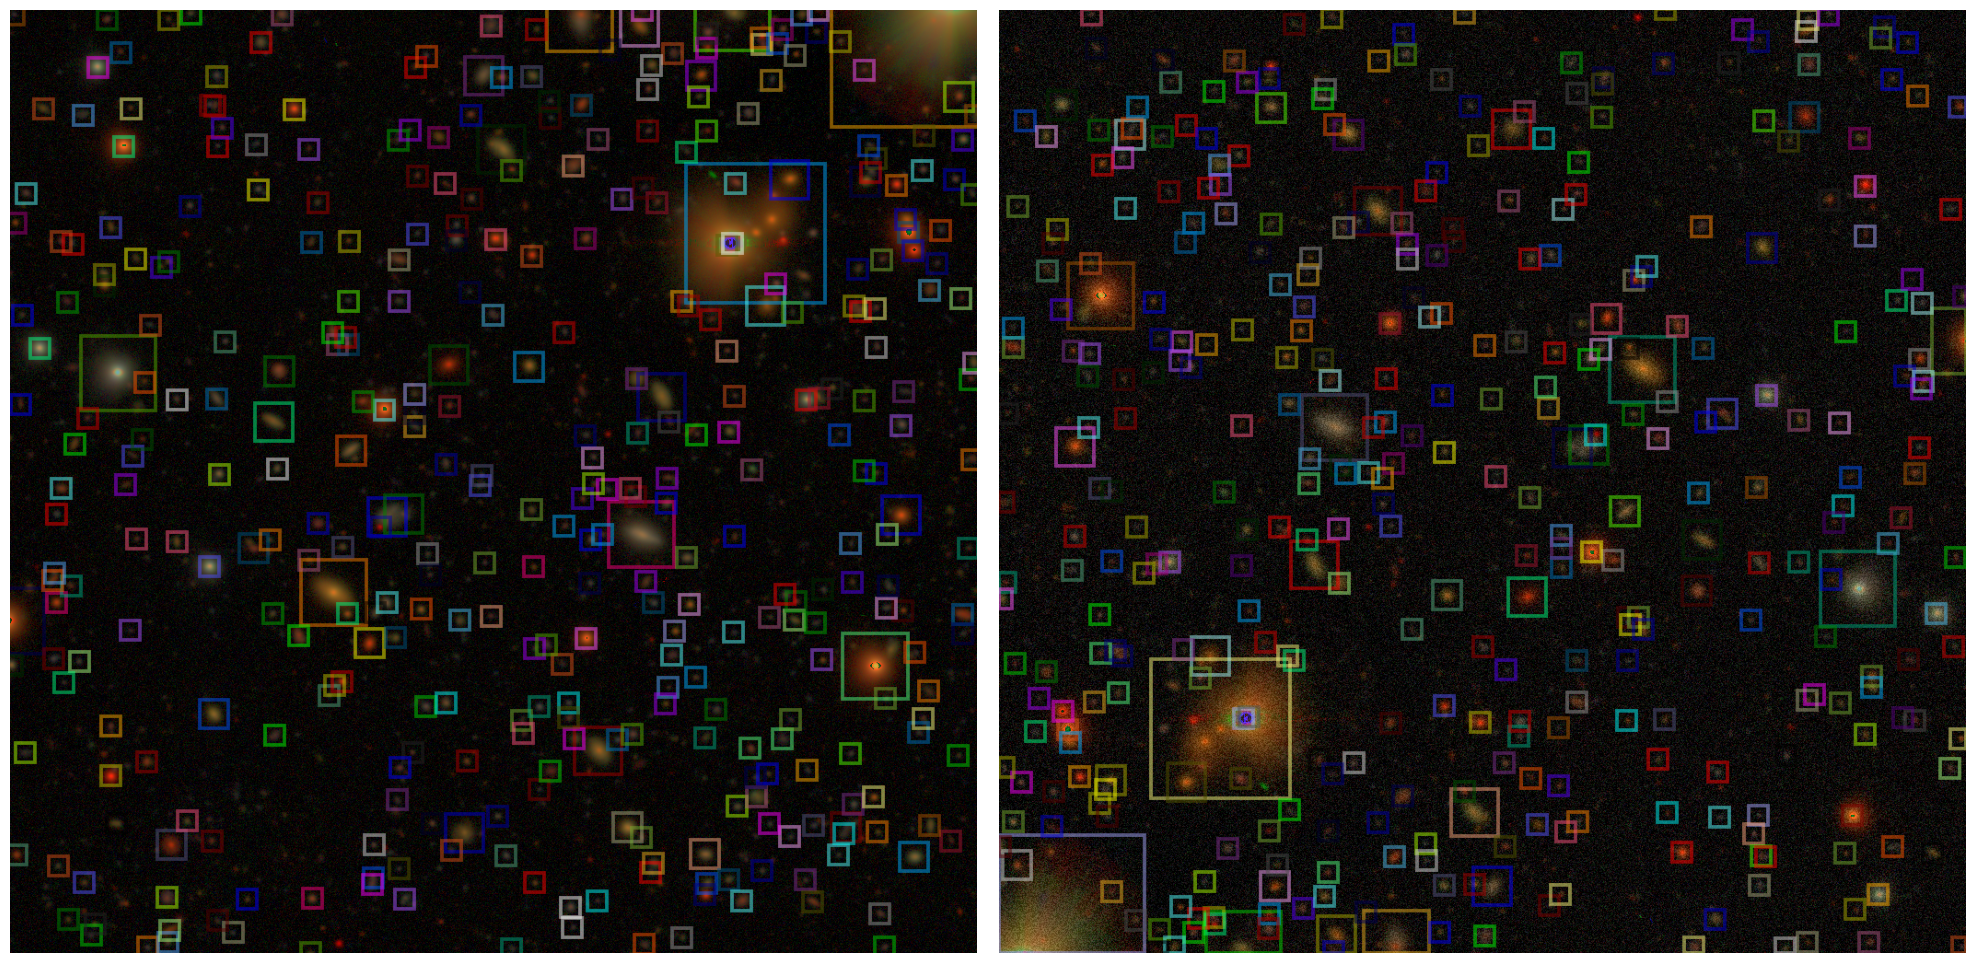

In [26]:
from detectron2.structures import BoxMode
fig, axs = plt.subplots(1,2, figsize=(10*2, 10))

#dictionary = iter(dataset_dicts['test_train'])
d = next(dictionary)
img = rescale_image(d, normalize="lupton", stretch=5, Q=10, ceil_percentile=99.995,dtype=np.uint8)
visualizer = Visualizer(img, metadata=MetadataCatalog.get("astro_train"), scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=MetadataCatalog.get("astro_train"), scale=1)
print(img_aug.shape)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

In [10]:
def check_image(dataset_dict, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8, A=1e4,hsc=True):
    # Read image
    if hsc:
        g = fits.getdata(os.path.join(dataset_dict['filename_G']), memmap=False)
        r = fits.getdata(os.path.join(dataset_dict['filename_R']), memmap=False)
        z = fits.getdata(os.path.join(dataset_dict['filename_I']), memmap=False)
    else:
        filename = dataset_dict['file_name']
        g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
        r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
        z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
        # Contrast scaling / normalization
    I = (z + r + g)/3.0
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
        max_RGB = np.nanpercentile([z, r, g], ceil_percentile)

        #max_RGB = np.max([g,r,z])


        # avoid saturation
        r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        max_dtype = np.iinfo(dtype).max
        r = r*max_dtype
        g = g*max_dtype
        z = z*max_dtype
        
        
    elif normalize.lower() == 'zscore':
        
        
        #Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        #z = (z - np.nanmean(z) - m)/Isigma
        # = (r - np.nanmean(r) - m)/Isigma
        #g = (g - np.nanmean(g) - m)/Isigma
        
        zsigma = np.nanstd(z)
        rsigma = np.nanstd(r)
        gsigma = np.nanstd(g)
        
        z = A*(z - np.nanmean(z) - m)/zsigma
        r = A*(r - np.nanmean(r) - m)/rsigma
        g = A*(g - np.nanmean(g) - m)/gsigma
        
        #max_RGB = np.nanpercentile([z, r, g], ceil_percentile) *2

        # avoid saturation
        #r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

        # Rescale to 0-255 for dtype=np.uint8
        #max_dtype = np.iinfo(dtype).max
        #r = r*max_dtype
        #g = g*max_dtype
        #z = z*max_dtype
        
        
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')



    # 0-255 RGB image
    image[:,:,0] = z # red
    image[:,:,1] = r # green
    image[:,:,2] = g # blue

    return image

In [15]:
def return_image(dataset_dict, hsc=True):
    # Read image
    if hsc:
        g = fits.getdata(os.path.join(dataset_dict['filename_G']), memmap=False)
        r = fits.getdata(os.path.join(dataset_dict['filename_R']), memmap=False)
        z = fits.getdata(os.path.join(dataset_dict['filename_I']), memmap=False)
    else:
        filename = dataset_dict['file_name']
        g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
        r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
        z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    #length, width = g.shape
    #image = np.empty([length, width, 3])
    
    # Options for contrast scaling
    
    # 0-255 RGB image
    #image[:,:,0] = z # red
    #image[:,:,1] = r # green
    #image[:,:,2] = g # blue

    #return image
    return z,r,g

In [17]:
import warnings
warnings.filterwarnings("error")

warnings.resetwarnings()

In [13]:
for i, d in enumerate(dataset_dicts_hsc['test']):
    try:
        img = rescale_image(d, normalize="lupton", stretch=5, Q=10, ceil_percentile=99.99,dtype=np.uint8)
    except RuntimeWarning:
        print(i)

5


/tmp/ipykernel_2247426/1920319491.py:19: RuntimeWarning: invalid value encountered in true_divide
  z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_2247426/1920319491.py:20: RuntimeWarning: invalid value encountered in true_divide
  r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
/tmp/ipykernel_2247426/1920319491.py:21: RuntimeWarning: invalid value encountered in true_divide
  g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)


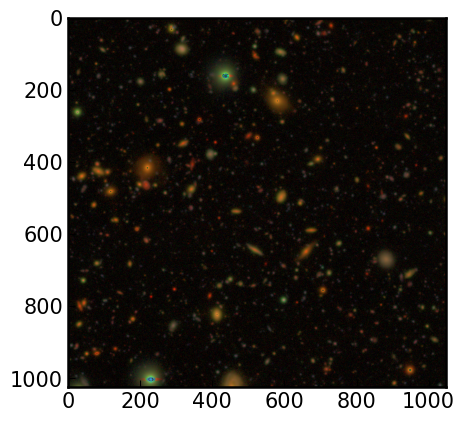

In [32]:
#d=random.sample(dataset_dicts['train'],1)[0]
d = dataset_dicts_hsc['test'][5]
im = check_image(d,normalize='lupton',ceil_percentile=99.99)
plt.imshow(im)

In [36]:
im.shape
im[577,747]


array([0, 0, 0], dtype=uint8)

In [26]:
z,r,g = return_image(d)



In [21]:
Q=10
stretch=5
I = (z+r+g)/3.0
#I = np.sum(rawim,axis=2)/3.0
z = z*np.arcsinh(stretch*Q*(I - 0))/(Q*I)

print(z)

[[ 0.11102843  0.06798252 -0.06467556 ...  0.1663499  -0.02102724
  -0.03625727]
 [-0.01071923  0.22384562 -0.00248106 ...  0.23421353 -0.00752664
  -0.35593766]
 [-0.1621629   0.02437623  0.01822322 ...  0.09114098 -0.00845794
   0.16577089]
 ...
 [ 0.22712341  0.12682843  0.17911766 ... -0.05678422  0.2576978
   0.09709854]
 [ 0.20991614  0.1866713   0.21171503 ...  0.06745018 -0.11775029
  -0.06811658]
 [ 0.13487251  0.2622456   0.24716675 ...  0.02763827  0.0331426
   0.23137742]]


/tmp/ipykernel_2247426/3766152759.py:5: RuntimeWarning: invalid value encountered in true_divide
  z = z*np.arcsinh(stretch*Q*(I - 0))/(Q*I)


In [29]:
z[np.isnan(z)]
np.where(np.isnan(z))

print(z[577,747])
print(r[577,747])
print(g[577,747])

print((z+r+g)[577,747])

-0.0005241538
0.015168638
-0.014644484
0.0


In [30]:
print(-0.0005241538+0.015168638+-0.014644484)

2.0000000093556292e-10


In [31]:
z[577,747]+r[577,747]+g[577,747]

0.0